In [ ]:
import sys
# sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV')
sys.path.append(r'C:\Users\dpoppema\Documents\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05')

import os
import numpy as np
import xarray as xr
import puv
from scipy.ndimage import uniform_filter1d

In [75]:
def movmean(x, N):
    # calculate moving mean. NB: this divides values at the edges by the window length, instead of the available number of values
    y = uniform_filter1d(x, size=N, mode='constant') # for even window: backward avg. So window 2: x_m(i)=[x(i-1)+x(i)]/2. x_m(i=1) = x(i=1)/2

    # compensate edges for number of values, i.e. the truncated window length
    S1 = np.arange(np.ceil(N/2), N)
    S2 = np.ones(len(x)-N+1)*N
    S3 = np.arange(N-1, np.floor(N/2), -1)
    S = np.concatenate((S1, S2, S3)) 
    return y * N / S
    # for 2D inspiration, see https://stackoverflow.com/questions/23000260/numpy-two-dimensional-moving-average

In [76]:
# general settings

# bed level
zb = 0.68 #m NAP

# height of instrument above bed
hi = 1.065 - zb #m
# height of instruments pressure sensor above bed
hip = hi - 0.3 #m

# angle of x-pod of the vector head with respect to north (clockwise positive)
thet = 360-55.2 # degrees

# density of water
rho = 1027 # kg/m3
# gravitational acceleration
g = 9.8125 # m/s2


In [77]:
import pandas as pd

# parameters for the quality control:
QC = {
     'uLim':2.1, #maximum acceptable recorded u-velocity
     'vLim':2.1, #maximum acceptable recorded v-velocity
     'wLim':0.6, #maximum acceptable recorded w-velocity
     'corTreshold':70, #minimum correlation
     'maxFracNans': 0.02, #maximum fraction of rejected pings in the sample to proceed with processing based on interpolation
     'maxGap' : 4 #maximum amount of sequential rejected pings in the sample to proceed with processing based on interpolation
      }

## load the data
ds = xr.open_dataset(r"O:\HybridDune experiment\data ADV, OBS\raw NetCDF\ADV_RWS3_Deployment1.nc")

# % add some data to the dataset
ds['zb'] = zb

ds['zi'] = ds['zb'] + hi
ds['zi'].attrs = {'units': 'm+NAP', 'long_name': 'position probe'}

ds['zip'] = ds['zb'] + hip
ds['zip'].attrs = {'units': 'm+NAP', 'long_name': 'position pressure sensor'}

ds['rho'] = rho
ds['rho'].attrs = {'units': 'kg/m3', 'long_name': 'water density'}

ds['g'] = g
ds['g'].attrs = {'units': 'm', 'long_name': 'gravitational acceleration'}

# if correlation is outside confidence range
mc1 = ds.cor1 > QC['corTreshold']
mc2 = ds.cor2 > QC['corTreshold']
mc3 = ds.cor3 > QC['corTreshold']

# if observation is outside of velocity range
mu1 = np.abs(ds.u) < QC['uLim']
mu2 = np.abs(ds.v) < QC['uLim']
mu3 = np.abs(ds.w) < QC['uLim']

# if du larger than 4*std(u) then we consider it outlier and hence remove:
md1 = np.abs(ds.u.diff('N')) < 3 * ds.u.std(dim='N')
md1 = md1.combine_first(mu1)
md2 = np.abs(ds.v.diff('N')) < 3 * ds.v.std(dim='N')
md2 = md1.combine_first(mu2)
md3 = np.abs(ds.w.diff('N')) < 3 * ds.w.std(dim='N')
md3 = md1.combine_first(mu3)

ds['mc'] = np.logical_and(np.logical_and(mc1, mc2), mc3)
ds['mu'] = np.logical_and(np.logical_and(mu1, mu2), mu3)
ds['md'] = np.logical_and(np.logical_and(md1, md2), md3)
ds['mc'].attrs = {'units': '-', 'long_name': 'mask correlation'}
ds['mu'].attrs = {'units': '-', 'long_name': 'mask vel limit'}
ds['md'].attrs = {'units': '-', 'long_name': 'mask deviation'}

mp = np.abs(ds.p.diff('N')) < 4 * ds.p.std(dim='N')    # mask for pressure, if pressure difference is larger than 4*std(p) then we consider it outlier and remove it
mp = xr.concat([mp.isel(N=0), mp], dim="N")            # add first value to the mask, because mask length is one shorter than the data length (because of the diff)

ds.coords['maskp'] = (('t', 'N'), mp.values)
ds.coords['maskv'] = (('t', 'N'), np.logical_and(np.logical_and(ds.mc.values, ds.mu.values), ds.md.values))

In [78]:
ds

<xarray.Dataset> Size: 923MB
Dimensions:   (t: 249, N: 28720)
Coordinates:
  * t         (t) datetime64[ns] 2kB 2024-12-13T10:00:00 ... 2024-12-23T18:00:00
  * N         (N) float64 230kB 0.0 0.125 0.25 ... 3.59e+03 3.59e+03 3.59e+03
    maskp     (t, N) bool 7MB True True True True True ... True True True True
    maskv     (t, N) bool 7MB False False False False ... False False False
Data variables: (12/44)
    sf        float64 8B ...
    p         (t, N) int64 57MB 4860 4860 4790 4790 4750 ... 4400 4520 4550 4440
    u         (t, N) float64 57MB -0.462 -1.789 -0.437 ... -2.114 1.053 -0.697
    v         (t, N) float64 57MB -0.731 -0.638 -0.289 ... 1.054 -1.941 0.755
    w         (t, N) float64 57MB 0.096 -0.002 0.022 ... -0.421 -0.294 -0.032
    anl1      (t, N) uint16 14MB ...
    ...        ...
    zip       float64 8B 0.765
    rho       int64 8B 1027
    g         float64 8B 9.812
    mc        (t, N) bool 7MB False False False False ... False False False
    mu        (t, N) bool 7MB True True True True True ... True False True True
    md        (t, N) bool 7MB True True True True True ... True True True True
Attributes: (12/15)
    Conventions:               CF-1.6
    title:                     ADV_RWS3_Deployment1
    instrument:                vec1
    instrument serial number:  16725
    epsg:                      28992
    x:                         117196.6
    ...                        ...
    summary:                   hybrid-Dune field campaign
    contact person:            Ruben Rosman 
    emailadres:                r.g.c.rosman@student.tudelft.nl
    construction datetime:     23-Jul-2025 (18:16:54)
    version:                   v1
    version comments:          constructed with xarray

In [79]:
# # ATMOSPHERIC PRESSURE CORRECTION 
# Set smoothing window for atmpospheric pressure
T_smooth_air = 10 # [s]     # measured with 8 hz. But p_water and p_air are measured up to 100m apart (and p_air inside). Affected different by wind gusts, so filter out short-term variation

# Open raw data file  of reference sensor 
dataFile =r'O:\HybridDune experiment\data RBR, OSSI\copy RBR Udrive series1\raw NetCDF\refP1 RBR4 raw data - period 1.nc'
ds0 = xr.open_dataset(dataFile)

# Determine moving average. 
ds0.p.values = movmean(ds0.p.values, 8*T_smooth_air) # smooth over 8hz * n seconds

# Add instrument calibration
ds0.p.values = ds0.p.values + -543 # for pressure in Pa. Coefficient for instrument ref.P1 RBR4

# -------------------------------------------------------------------------------------------
# Cast reference (air) pressure in same 2D array as ADV data
# frequency resolution in fourier space 
D_length_s = '3600s'   # Duration of block in seconds (20 minutes). NB: DAAN: CHANGE WHEN BLOCK LENGTH CHANGES!

# reshape to one column per burst in data array
pt = ds0.p.values 
nSamples = len(pt)
dt = ds0.isel(t=1).t - ds0.isel(t=0).t

burstDuration = pd.Timedelta(D_length_s)  # Burst duration (1200 seconds = 20 minutes)
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
t_full = ds0.t.values[:nBursts * burstLength]  # time vector for all samples, up to the last complete burst. skip incomplete burst at end
t_block = t_full[::burstLength]  # take every nth step, so t = t0 of every burst

N = (ds0.t.values[:burstLength] - ds0.t.values[0]) / np.timedelta64(1, 's')  # time in seconds since start of burst

# Cast pressure into a 2D array 
ds_2D = xr.Dataset(data_vars={},    # Temporary 2D dataset, with cooridnates t (no. of blocks), N (obs within block)
                coords={'t': t_block,
                        'N': N})
ds_2D['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))      # relative pressure, pAir subtracted

# Calculate relative pressure (i.e. subtract atmospheric pressure)
ds['pc'] = ds['p'] + 98380 - ds_2D['p']  # 98380 based on calibration (comparison to ref sensor) for 16 dec 2024, 21:00-22:00. NB: XArray finds the corresponding time steps automatically, no need to crop to the same time range

# Metedata
ds['pc'].attrs = {'units': 'Pa', 'long_name': 'pressure', 'comments': 'Relative pressure, so corrected for air pressure'}


In [80]:
ds['eta'] = ds['pc'] / rho / g + ds.zip
ds['eta'].attrs = {'units': 'm+NAP', 'long_name': 'hydrostatic water level'}

ds['zsmean'] = ds.eta.mean(dim='N')
ds['zsmean'].attrs = {'units': 'm + NAP', 'long_name': 'water level',
                      'comments': 'burst averaged'}

ds['h'] = ds.zsmean - zb
ds['h'].attrs = {'units': 'm', 'long_name': 'water column height'}

In [81]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:   (t: 249, N: 28720)
Coordinates:
  * t         (t) datetime64[ns] 2kB 2024-12-13T10:00:00 ... 2024-12-23T18:00:00
  * N         (N) float64 230kB 0.0 0.125 0.25 ... 3.59e+03 3.59e+03 3.59e+03
    maskp     (t, N) bool 7MB True True True True True ... True True True True
    maskv     (t, N) bool 7MB False False False False ... False False False
Data variables: (12/48)
    sf        float64 8B ...
    p         (t, N) int64 57MB 4860 4860 4790 4790 4750 ... 4400 4520 4550 4440
    u         (t, N) float64 57MB -0.462 -1.789 -0.437 ... -2.114 1.053 -0.697
    v         (t, N) float64 57MB -0.731 -0.638 -0.289 ... 1.054 -1.941 0.755
    w         (t, N) float64 57MB 0.096 -0.002 0.022 ... -0.421 -0.294 -0.032
    anl1      (t, N) uint16 14MB ...
    ...        ...
    mu        (t, N) bool 7MB True True True True True ... True False True True
    md        (t, N) bool 7MB True True True True True ... True True True True
    pc        (t, N) float64 57MB -200.9 -200.9 -270.9 ... 112.2 142.3 32.3
    eta       (t, N) float64 57MB 0.7451 0.7451 0.7381 ... 0.7761 0.7791 0.7682
    zsmean    (t) float64 2kB 0.741 0.7418 0.7419 0.741 ... 0.7779 0.7723 0.7706
    h         (t) float64 2kB 0.06097 0.06181 0.06189 ... 0.0979 0.09233 0.09056
Attributes: (12/15)
    Conventions:               CF-1.6
    title:                     ADV_RWS3_Deployment1
    instrument:                vec1
    instrument serial number:  16725
    epsg:                      28992
    x:                         117196.6
    ...                        ...
    summary:                   hybrid-Dune field campaign
    contact person:            Ruben Rosman 
    emailadres:                r.g.c.rosman@student.tudelft.nl
    construction datetime:     23-Jul-2025 (18:16:54)
    version:                   v1
    version comments:          constructed with xarray

In [82]:
# #% rotate to ENU coordinates (this is only necessary if measurements were performed in XYZ
ufunc = lambda u,v: puv.rotate_velocities(u,v,thet-90)
ds['u'],ds['v'] = xr.apply_ufunc(ufunc,
                    ds['u'], ds['v'],
                    input_core_dims=[['N'], ['N']],
                    output_core_dims=[['N'],['N']],
                    vectorize=True)
ds['u'].attrs = {'units':'m/s','long_name':'velocity E'}
ds['v'].attrs = {'units':'m/s','long_name':'velocity N'}
ds['w'].attrs = {'units':'m/s','long_name':'velocity U'}

# remove pressure observations where the estimated water level is
# lower than the sensor height with margin of error of 10 cm
ds.coords['maskd'] = (('t', 'N'), zb+hi < (ds['eta'].values - 0.05))
ds[['u','v','w','p','pc','eta']] = ds[['u','v','w','p','pc','eta']].where(ds.maskp == True)
ds[['u','v','w','p','pc','eta']] = ds[['u','v','w','p','pc','eta']].where(ds.maskd == True)
ds[['u','v','w','p','pc','eta']] = ds[['u','v','w','p','pc','eta']].where(ds.maskv == True)

# ammending the meta data to add extra info
ds.attrs['version'] = 'v2'
ds.attrs['coordinate type'] = 'ENU'
ds.attrs['comment'] = 'Quality checked data: pressure reference level corrected for airpressure drift,' + \
                 r'correlation and amplitude checks done and spikes were removed. ' + \
                 r'Velocities rotated to ENU coordinates based on heading and configuration in the field.'

# save to netCDF wwhere we don't include the sen data any more because we have only used it for the quality check
ds = ds.drop(['a1', 'a2', 'a3',
              'cor1', 'cor2', 'cor3',
              'snr1', 'snr2', 'snr3',
              'heading', 'pitch', 'roll',
              'voltage', 'pc'])

C:\Users\dpoppema\AppData\Local\Temp\ipykernel_11744\4229189308.py:27: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(['a1', 'a2', 'a3',


In [83]:
# specify compression for all the variables to reduce file size
comp = dict(zlib=True, complevel=5)
ds.encoding = {var: comp for var in list(ds.data_vars) + list(ds.coords)}

ncOutDir = r"O:\HybridDune experiment\data ADV, OBS\QC"
if not os.path.exists(ncOutDir):
    os.mkdir(ncOutDir)
ds.to_netcdf(os.path.join(ncOutDir, 'QC_ADV_RWS3_Deployment1.nc'), encoding = ds.encoding)

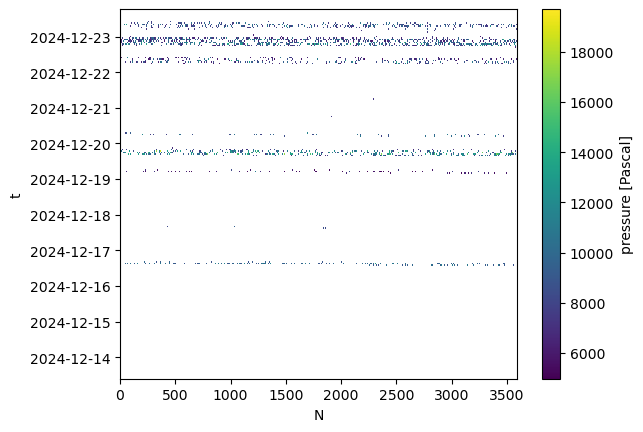

In [84]:
ds.p.plot()

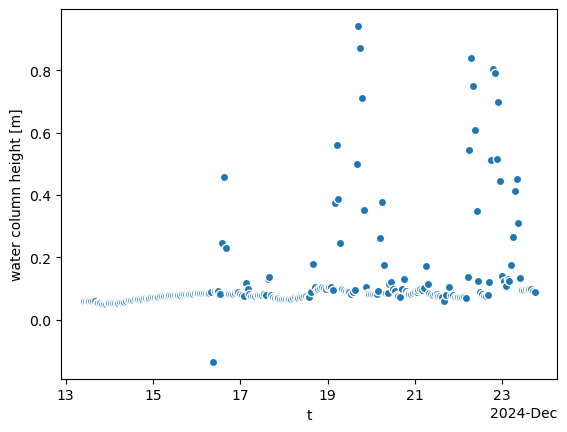

In [85]:
ds.h.plot.scatter()

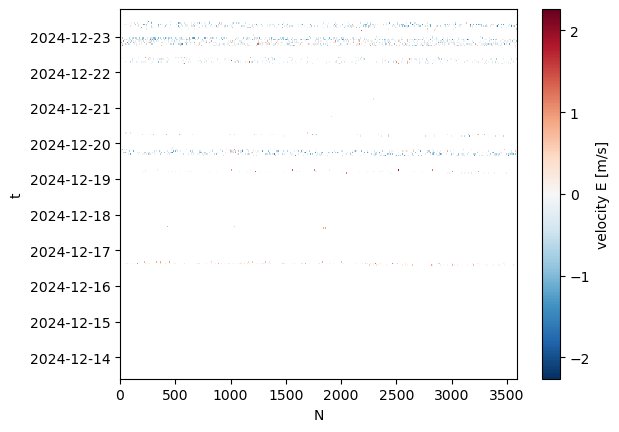

In [86]:
ds.u.plot()